In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline
sns.set()

In [2]:
df = pd.read_csv("../data/data_csv.csv")

In [3]:
df["Year"] = pd.DatetimeIndex(df['Date']).year 

In [4]:
vif = pd.DataFrame()
df_vif = df.drop("Date", axis=1)
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

               features  vif_Factor
0                 SP500  381.962424
1              Dividend  288.972458
2              Earnings  144.001576
3  Consumer Price Index   40.233282
4    Long Interest Rate   11.172129
5            Real Price  386.726001
6         Real Dividend  293.661481
7         Real Earnings  163.017104
8                  PE10   48.355051
9                  Year   68.838492

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


"Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. Mathematically, the VIF for a regression model variable is equal to the ratio of the overall model variance to the variance of a model that includes only that single independent variable. This ratio is calculated for each independent variable. A high VIF indicates that the associated independent variable is highly collinear with the other variables in the model."

(array([904., 302., 167.,  27.,  45.,  87.,  42.,  44.,  18.,   8.]),
 array([  87.63,  348.88,  610.13,  871.38, 1132.63, 1393.88, 1655.13,
        1916.38, 2177.63, 2438.88, 2700.13]),
 <a list of 10 Patch objects>)

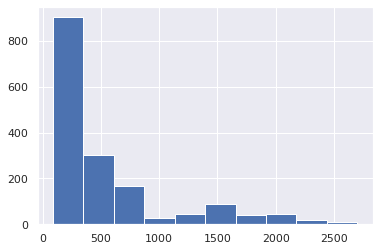

In [5]:
plt.hist(df["Real Price"])

(array([565., 320., 319., 231.,  89.,  39.,  29.,  14.,  12.,  26.]),
 array([ 6.22 , 10.557, 14.894, 19.231, 23.568, 27.905, 32.242, 36.579,
        40.916, 45.253, 49.59 ]),
 <a list of 10 Patch objects>)

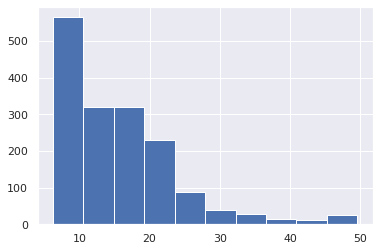

In [6]:
plt.hist(df["Real Dividend"])

(array([ 48., 313., 366., 172., 201., 176., 104.,  59., 135.,  70.]),
 array([4.47312341, 4.81591658, 5.15870976, 5.50150294, 5.84429612,
        6.1870893 , 6.52988248, 6.87267566, 7.21546884, 7.55826202,
        7.9010552 ]),
 <a list of 10 Patch objects>)

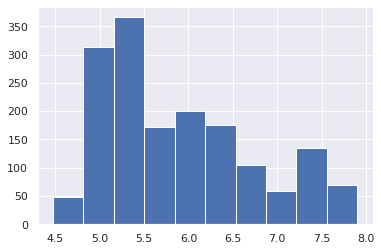

In [7]:
from scipy.stats import boxcox

data = boxcox(df["Real Price"], 0)
plt.hist(data)

### To calculate real returns we use the formula:
return[t] = return[t-1] * (((Real Price[t] - Real Price[t-1]) / Real Price[t-1])) + 1) + (Real Dividend[t-1]/RealPrice[t-1])

In [8]:
def calculate_real_return(start_year, end_year, previous_return, df_s):
    df_new_s = df_s[(df_s["Year"] >= start_year) & (df_s["Year"] < end_year)].reset_index(drop=True)
    
    diff_price = ((df_new_s["Real Price"].values[-1] - df_new_s["Real Price"].values[0]) / (df_new_s["Real Price"].values[0])) + 1
    cum_return = previous_return * diff_price
    reinvested_dividens = cum_return + (df_new_s["Real Dividend"].values[0] / df_new_s["Real Price"].values[0])

    return reinvested_dividens

In [9]:
start_y = 2000
end_y = 2018

previous_real_returns = []
previous_real_returns.append(1) # start with investing one dollar at the begining
i = 0

for y in range(start_y, end_y):
    real_return = calculate_real_return(y, y+1, previous_real_returns[i], df) 
    previous_real_returns.append(real_return)
    i += 1

In [10]:
len(previous_real_returns)

19

In [11]:
return_val = []
year = start_y
i = 0
year_count = []

df_new = df[df.Year>=start_y].reset_index(drop=True)

for idx, row in df_new.iterrows():
    if row.Year == year:
        return_val.append(previous_real_returns[i])
        year_count.append(i)
    else:
        year += 1
        i += 1
        return_val.append(previous_real_returns[i])
        year_count.append(i)

In [12]:
df_new = df_new.drop("Date", axis=1)
df_new["Return"] = return_val
df_new["InvestedYears"] = year_count
df_new = df_new.drop("Year", axis=1)

In [13]:
df_new.head()

,SP500,Dividend,Earnings,Consumer Price Index,Long Interest Rate,Real Price,Real Dividend,Real Earnings,PE10,Return,InvestedYears
0,1425.59,16.71,49.10,168.8,6.66,2109.97,24.74,72.67,43.77,1.0,0
1,1388.87,16.74,50.02,169.8,6.52,2043.52,24.63,73.60,42.19,1.0,0
2,1442.21,16.76,50.95,171.2,6.26,2104.65,24.46,74.35,43.22,1.0,0
3,1461.36,16.74,51.27,171.3,5.99,2131.35,24.41,74.78,43.53,1.0,0
4,1418.48,16.72,51.60,171.5,6.44,2066.39,24.36,75.16,41.97,1.0,0


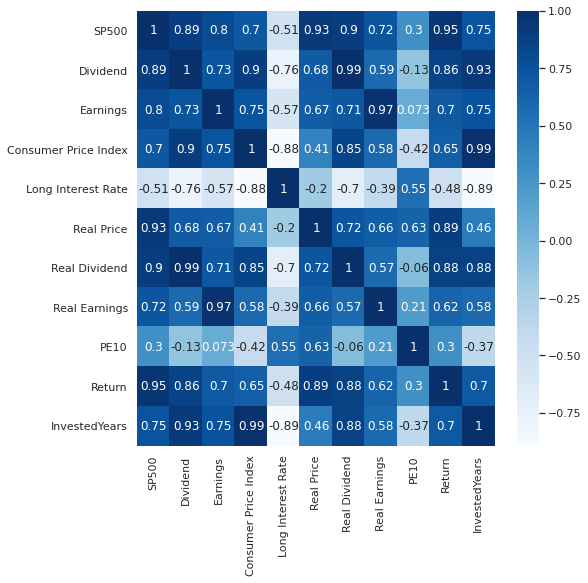

select those independent variables with high correlation with dependent variable


In [14]:
plt.figure(figsize=(8, 8))
sns.heatmap(df_new.corr(), annot=True, cmap=plt.cm.Blues)
plt.show()

print("select those independent variables with high correlation with dependent variable")

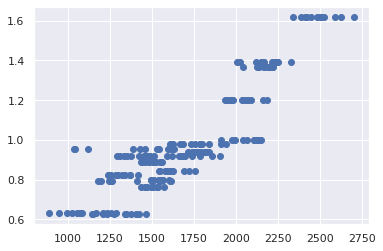

In [15]:
plt.scatter(df_new["Real Price"], df_new["Return"])

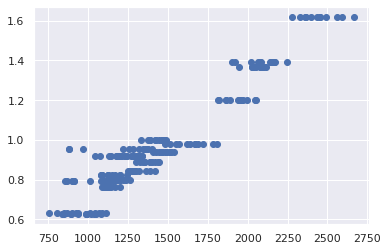

In [16]:
plt.scatter(df_new["SP500"], df_new["Return"])

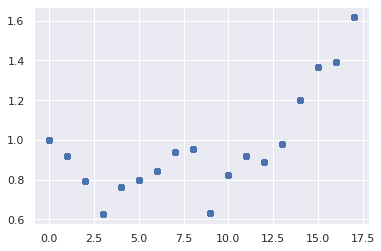

In [17]:
plt.scatter(df_new["InvestedYears"], df_new["Return"])

In [18]:
vif = pd.DataFrame()
df_vif = df_new[["SP500", "Real Price"]]
vif["features"] = df_vif.columns
vif["vif_Factor"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif)
print("\nIf VIF value is higher than 10, it is usually considered having high correlation with other independent variables.")

     features  vif_Factor
0       SP500   74.213667
1  Real Price   74.213667

If VIF value is higher than 10, it is usually considered having high correlation with other independent variables.


In [19]:
X = df_new[["SP500", "InvestedYears", "Real Price"]]
y = df_new[["Return"]]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [21]:
import statsmodels.api as sm

X_train_sm = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     519.8
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           1.33e-81
Time:                        18:38:19   Log-Likelihood:                 187.58
No. Observations:                 162   AIC:                            -367.2
Df Residuals:                     158   BIC:                            -354.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1234      0.071      1.745      0.083      -0.016       0.263
SP500             0.0005      0.000      2.288      0.023    7.09e-05       0.001
InvestedYears     0.0018      0.008      0.232      0.817      -0.013       0.017
Real Price     5.047e-05      0.000      0.260      0.795      -0.000       0.000
==============================================================================
Omnibus:                       18.397   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.750
Skew:                           0.609   Prob(JB):                     5.72e-07
Kurtosis:                       4.667   Cond. No.                     2.69e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
print(model.pvalues)

const            0.082956
SP500            0.023487
InvestedYears    0.817005
Real Price       0.795232
dtype: float64


In [23]:
lr = LinearRegression().fit(X_train, y_train)

In [24]:
def get_cv_scores(model):
    scores = cross_val_score(model, X_train, y_train, cv=10, scoring='r2')
    
    print('CV Mean: ', np.mean(scores))
    print('STD: ', np.std(scores))
    print('\n')

In [25]:
get_cv_scores(lr)

CV Mean:  0.8932080925642782
STD:  0.035060334880332875




In [26]:
y_pred = lr.predict(X_test)

In [27]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 0.01
Coefficient of determination: 0.90


## Using PCA to transform features

In [28]:
y = df_new[["Return"]]
X = df_new.drop("Return", axis=1)

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [30]:
def transform_features(num_components):
    scaler = MinMaxScaler()
    X_train_minmax = scaler.fit_transform(X_train)
    X_test_minmax = scaler.transform(X_test)
    
    pca = PCA(n_components=num_components)
    X_train_pca = pca.fit_transform(X_train_minmax)
    X_test_pca = pca.transform(X_test_minmax)
    return pca, X_train_pca, X_test_pca

In [31]:
pca, X_train_pca, X_test_pca = transform_features(0.99)

In [32]:
lr = LinearRegression().fit(X_train_pca, y_train)

In [33]:
y_pred = lr.predict(X_test_pca)

In [34]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 0.01
Coefficient of determination: 0.92


In [35]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     440.7
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           3.19e-84
Time:                        18:38:20   Log-Likelihood:                 197.13
No. Observations:                 162   AIC:                            -384.3
Df Residuals:                     157   BIC:                            -368.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9745      0.006    170.385      0.000       0.963       0.986
x1             0.2981      0.008     36.220      0.000       0.282       0.314
x2            -0.2912      0.017    -16.953      0.000      -0.325      -0.257
x3             0.3107      0.025     12.337      0.000       0.261       0.360
x4            -0.1999      0.059     -3.385      0.001      -0.317      -0.083
==============================================================================
Omnibus:                        2.637   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.268   Jarque-Bera (JB):                2.347
Skew:                           0.292   Prob(JB):                        0.309
Kurtosis:                       3.079   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
cv = cross_val_score( LinearRegression(), X_train_pca, y_train, cv=10)
print(f"Mean cross-validation score: {cv.mean():.4f}")

Mean cross-validation score: 0.8983


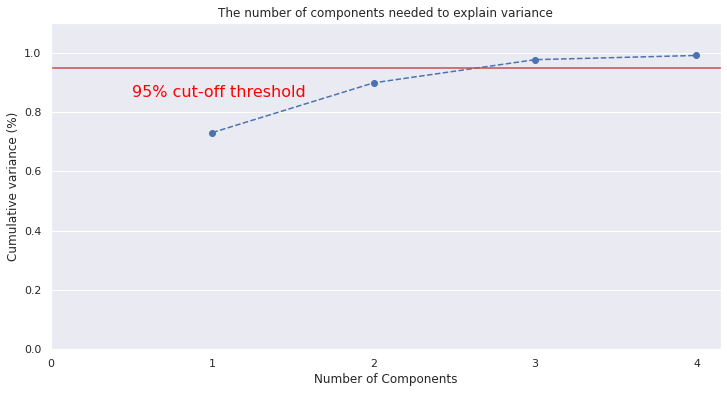

In [37]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
end_d = 6 if start_y != 2000 else 5
xi = np.arange(1, end_d, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, end_d, step=1))
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [38]:
pca, X_train_pca, X_test_pca = transform_features(3) # try with 3 components

In [39]:
X_train_sm = sm.add_constant(X_train_pca)
model = sm.OLS(y_train, X_train_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     547.6
Date:                Tue, 20 Oct 2020   Prob (F-statistic):           3.14e-83
Time:                        18:38:20   Log-Likelihood:                 191.43
No. Observations:                 162   AIC:                            -374.9
Df Residuals:                     158   BIC:                            -362.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9745      0.006    165.013      0.000       0.963       0.986
x1             0.2981      0.008     35.078      0.000       0.281       0.315
x2            -0.2912      0.018    -16.418      0.000      -0.326      -0.256
x3             0.3107      0.026     11.948      0.000       0.259       0.362
==============================================================================
Omnibus:                        1.283   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.527   Jarque-Bera (JB):                1.378
Skew:                           0.181   Prob(JB):                        0.502
Kurtosis:                       2.729   Cond. No.                         4.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
lr = LinearRegression().fit(X_train_pca, y_train)
y_pred = lr.predict(X_test_pca)

In [41]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

cv = cross_val_score(LinearRegression(), X_train_pca, y_train, cv=10)
print(f"Mean cross-validation score: {cv.mean():.4f}")

Mean squared error: 0.01
Coefficient of determination: 0.92
Mean cross-validation score: 0.8900


In [42]:
y_pred.tolist()
y_pred_list = [i[0] for i in y_pred.tolist()]

Text(0, 0.5, 'Return')

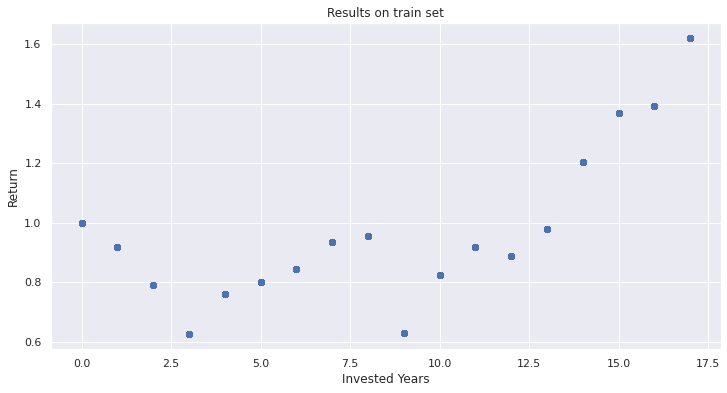

In [43]:
plt.scatter(list(X_train["InvestedYears"]), list(y_train.Return))
plt.title("Results on train set")
plt.xlabel("Invested Years")
plt.ylabel("Return")

Text(0, 0.5, 'Return')

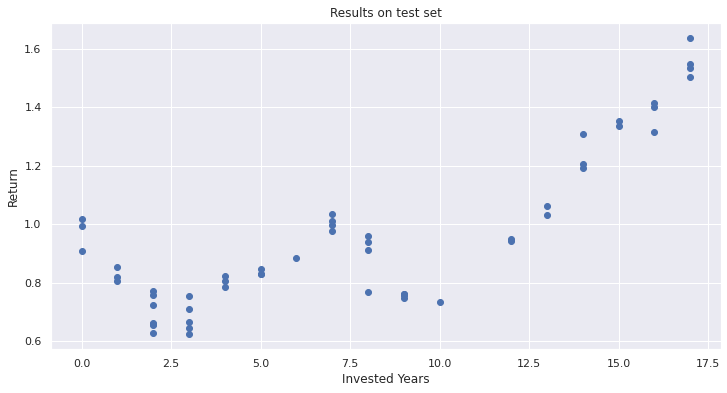

In [44]:
plt.scatter(list(X_test["InvestedYears"]), y_pred_list)
plt.title("Results on test set")
plt.xlabel("Invested Years")
plt.ylabel("Return")

In [45]:
updated_df = pd.read_csv("../data/U.S. Stock Markets 1871-Present.csv")

In [46]:
years = []
for idx, row in updated_df.iterrows():
    years.append(int(str(row["Date"]).split('.')[0]))

In [47]:
updated_df["Year"] = years

In [48]:
# we don't have whole year in 2020 so we exclude 2020
start_y = 2018
end_y = 2020
updated_df = updated_df[(updated_df["Year"] >= start_y) & (updated_df["Year"] < end_y)].reset_index(drop=True)

updated_df.drop("Date", axis=1, inplace=True)
updated_df = updated_df.drop(["RealTRScaledEarnings", "Real Total Return Price"], axis=1)

In [49]:
updated_df

,S&PComp,Dividend,Earnings,ConsumerPriceIndexCPI,Long Interest Rate GS10,Real Price,Real Dividend,Real Earnings,Year
0,2789.80,49.29,111.73,247.87,2.58,2923.58,51.65,117.09,2018
1,2705.16,49.64,113.59,248.99,2.86,2822.08,51.79,118.50,2018
2,2702.77,50.00,115.44,249.55,2.84,2813.23,52.04,120.16,2018
3,2653.63,50.33,117.79,250.55,2.87,2751.14,52.18,122.12,2018
4,2701.49,50.66,120.13,251.59,2.98,2789.16,52.30,124.03,2018
5,2754.35,50.99,122.48,251.99,2.91,2839.21,52.56,126.25,2018
6,2793.64,51.44,125.12,252.01,2.89,2879.52,53.02,128.96,2018
7,2857.82,51.89,127.75,252.15,2.89,2944.04,53.46,131.61,2018
8,2901.50,52.34,130.39,252.44,3.00,2985.57,53.86,134.17,2018
9,2785.46,52.81,131.06,252.89,3.15,2861.11,54.24,134.62,2018


In [50]:
previous_real_returns = []
previous_real_returns.append(1) # start with investing one dollar at the begining
i = 0

for y in range(start_y, end_y):
    real_return = calculate_real_return(y, y+1, previous_real_returns[i], updated_df) 
    previous_real_returns.append(real_return)
    i += 1

In [51]:
return_val = []
year = start_y
i = 0
year_count = []

for idx, row in updated_df.iterrows():
    if row.Year == year:
        return_val.append(previous_real_returns[i])
        year_count.append(i)
    else:
        year += 1
        i += 1
        return_val.append(previous_real_returns[i])
        year_count.append(i)

In [52]:
updated_df["Return"] = return_val
updated_df["InvestedYears"] = year_count
updated_df = updated_df.drop("Year", axis=1)

In [53]:
y = updated_df[["Return"]]
X = updated_df.drop("Return", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [54]:
pca, X_train_pca, X_test_pca = transform_features(3) # try with 3 components

In [55]:
y_pred = lr.predict(X_test_pca)

In [56]:
# The mean squared error
print('Mean squared error: %.2f' % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 0.14
Coefficient of determination: -177.19
